In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, KFold

## Embedding datasets and dimensionality overview

In [3]:
bert = pickle.load(open("bert_embedding.pkl", "rb"))
openai=pickle.load(open("openai_embedding.pkl", "rb"))
bow=pickle.load(open("bow_embedding.pkl", "rb"))
bertX_train = bert['train']['x']
berty_train = bert['train']['y']
bertX_test = bert['test']['x']
berty_test = bert['test']['y']

openaiX_train = openai['train']['x']
openaiy_train = openai['train']['y']
openaiX_test = openai['test']['x']
openaiy_test = openai['test']['y']

bowX_train = bow['train']['x']
bowy_train = bow['train']['y']
bowX_test = bow['test']['x']
bowy_test = bow['test']['y']


In [4]:
print(bertX_train.shape)
print(berty_train.shape)
print(bertX_test.shape)
print(berty_test.shape)

(6424, 768)
(6424,)
(2754, 768)
(2754,)


In [5]:
print(openaiX_train.shape)
print(openaiy_train.shape)
print(openaiX_test.shape)
print(openaiy_test.shape)

(6424, 3072)
(6424,)
(2754, 3072)
(2754,)


In [6]:
print(bowX_train.shape)
print(bowy_train.shape)
print(bowX_test.shape)
print(bowy_test.shape)

(6424, 2474)
(6424,)
(2754, 2474)
(2754,)


## PCA-based visualization of embedding spaces

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [9]:
pca_bert = PCA(n_components=2)
dat_pca_bert = pca_bert.fit_transform(bertX_train)
pca_open = PCA(n_components=2)
dat_pca_open = pca_open.fit_transform(openaiX_train)
pca_bow = PCA(n_components=2)
dat_pca_bow = pca_bow.fit_transform(bowX_train)

print("OpenAI PCA std:", dat_pca_open.std(axis=0))
print("BERT  PCA std:", dat_pca_bert.std(axis=0))
print("BoW   PCA std:", dat_pca_bow.std(axis=0))

OpenAI PCA std: [0.23231247 0.19259795]
BERT  PCA std: [3.0270527  1.58650146]
BoW   PCA std: [3.08380791 1.55621198]


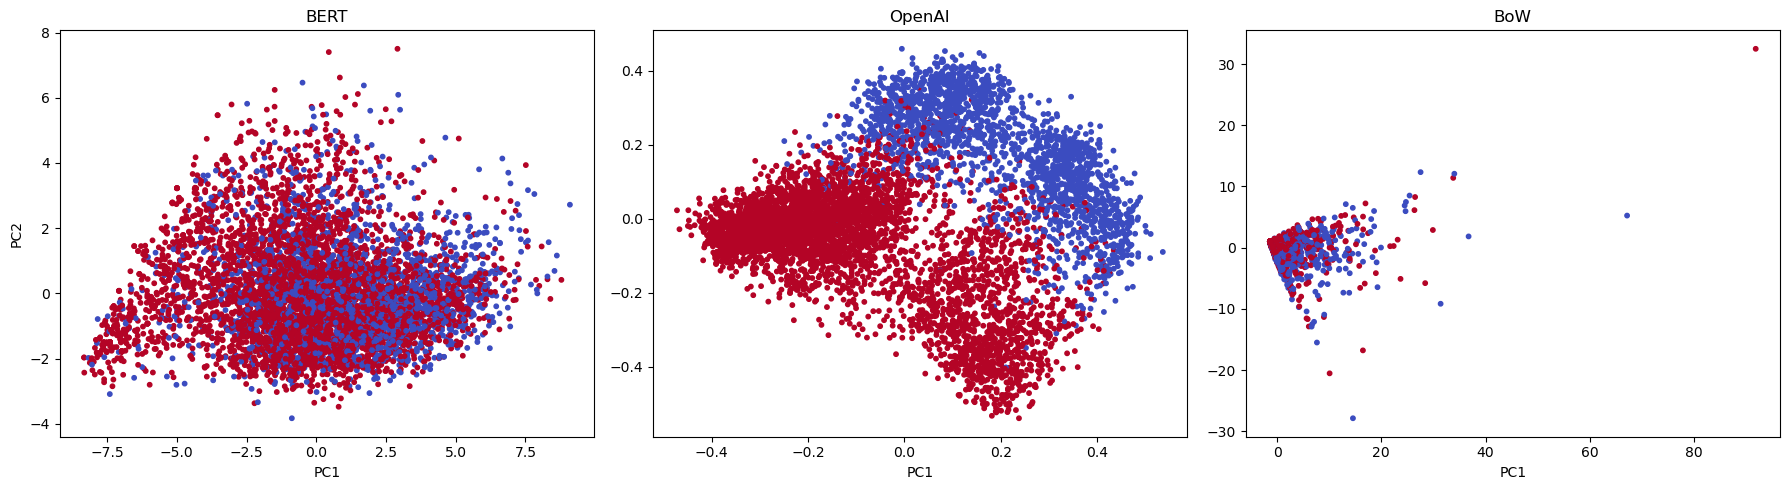

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False, sharey=False) 
axes[0].scatter(dat_pca_bert[:,0], dat_pca_bert[:,1], c=berty_train, cmap='coolwarm', s=10)
axes[0].set_title('BERT')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

axes[1].scatter(dat_pca_open[:,0], dat_pca_open[:,1],
                c=openaiy_train, cmap='coolwarm', s=10)
axes[1].set_title('OpenAI')
axes[1].set_xlabel('PC1')

axes[2].scatter(dat_pca_bow[:,0], dat_pca_bow[:,1],
                c=bowy_train, cmap='coolwarm', s=10)
axes[2].set_title('BoW')
axes[2].set_xlabel('PC1')

plt.tight_layout()
plt.show()

Across the three text representations (BERT, OpenAI embeddings, and BoW), the 2D PCA projections do not yield a clean linear separation between the two classes: substantial overlap remains in all cases. That said, the OpenAI embeddings exhibit more visible structure, with regions where one class is denser than the other, although the classes still overlap. In contrast, the BERT projection appears more mixed in the first two components, and the BoW projection is strongly affected by sparsity and outliers, which can dominate the PCA directions. Importantly, PCA is an unsupervised, variance-maximizing method, so lack of separation in PC1–PC2 does not imply the classes are inseparable; separation may exist in higher components or via nonlinear decision boundaries.

## Nonlinear dimensionality reduction with UMAP

In [11]:
import umap.umap_ as umap


In [12]:
umap_model_bert = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.1, random_state=10)
bert_umap = umap_model_bert.fit_transform(bertX_train)
umap_model_open = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.1, random_state=10)
open_umap = umap_model_open.fit_transform(openaiX_train)
umap_model_bow = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.1, random_state=10)
bow_umap = umap_model_bow.fit_transform(bowX_train)

C:\Users\Admin\anaconda3\envs\ml311-py311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Admin\anaconda3\envs\ml311-py311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Admin\anaconda3\envs\ml311-py311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


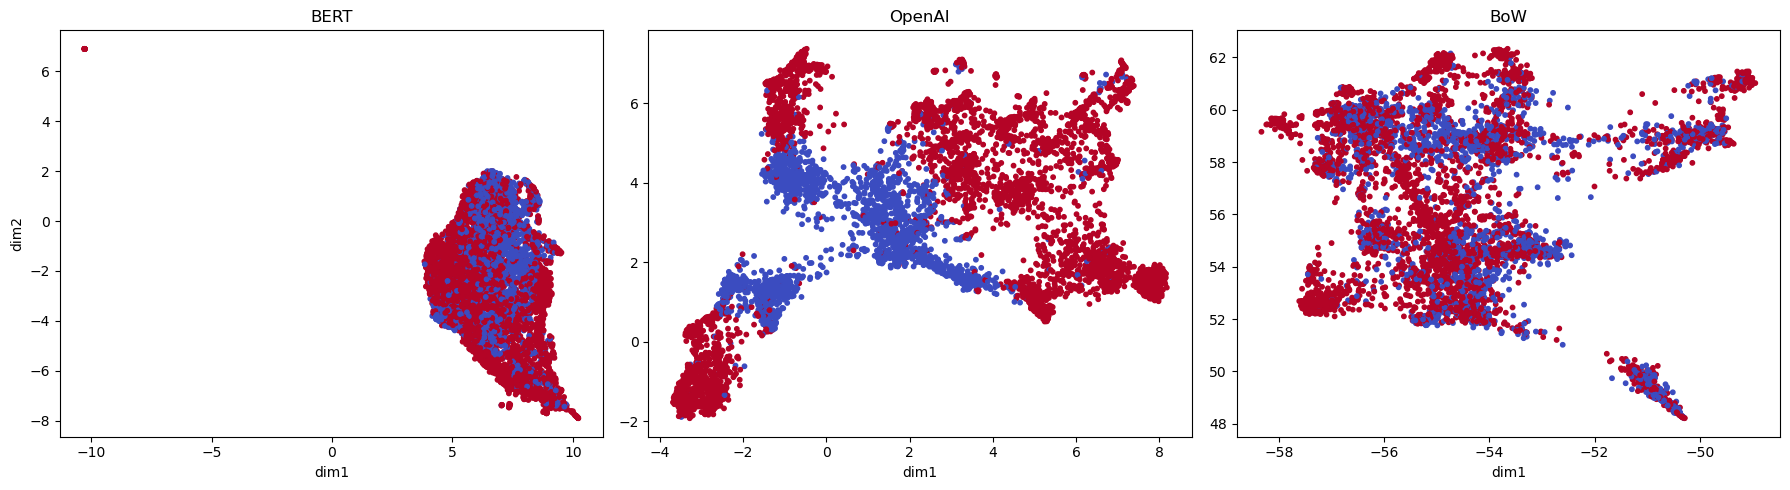

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False, sharey=False) 
axes[0].scatter(bert_umap[:,0], bert_umap[:,1], c=berty_train,  cmap='coolwarm', s=10)
axes[0].set_title('BERT')
axes[0].set_xlabel('dim1')
axes[0].set_ylabel('dim2')

axes[1].scatter(open_umap[:,0], open_umap[:,1],
                c=openaiy_train, cmap='coolwarm', s=10)
axes[1].set_title('OpenAI')
axes[1].set_xlabel('dim1')

axes[2].scatter(bow_umap[:,0], bow_umap[:,1],
                c=bowy_train, cmap='coolwarm', s=10)
axes[2].set_title('BoW')
axes[2].set_xlabel('dim1')

plt.tight_layout()
plt.show()

I used UMAP to quickly sanity-check how different text representations “cluster” similar reviews before training models. In 2D, none of the methods produces a perfectly clean split between the two labels, which tells me I shouldn’t expect a simple boundary from visualization alone. The key difference is in structure: OpenAI embeddings form clearer regions where one label is more concentrated, suggesting the representation captures label-relevant semantics better; BERT looks more blended in this projection; and BoW appears more fragmented and noisy, which is consistent with sparse high-dimensional features. I treat UMAP as a qualitative diagnostic (and it can change with settings), so I don’t claim it proves separability—rather, it helps justify why embedding choice matters and why downstream classification should rely on proper evaluation, not just plots.

## Baseline Naive Bayes classification (alpha = 4)


In [102]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler


In [103]:
bownb_full = MultinomialNB(alpha=4)
bownb_full.fit(bowX_train, bowy_train)
bowlabel_full = bownb_full.predict(bowX_test)
confmat_full = confusion_matrix(bowy_test, bowlabel_full)
print("Naive Bayes Confusion Matrix BOW:")
print(confmat_full)
misrate_full = 1 - accuracy_score(bowy_test, bowlabel_full)
print(f"Naive Bayes Misclassification Rate BOW: {misrate_full:.4f}")

Naive Bayes Confusion Matrix BOW:
[[ 701  241]
 [ 152 1660]]
Naive Bayes Misclassification Rate BOW: 0.1427


In [104]:
scaler_bert = MinMaxScaler()
bert_scale_train_x = scaler_bert.fit_transform(bertX_train)
bert_scale_test_x = scaler_bert.transform(bertX_test)
scaler_open = MinMaxScaler()
open_scale_train_x = scaler_open.fit_transform(openaiX_train)
open_scale_test_x = scaler_open.transform(openaiX_test)

In [105]:
bertnb_full = MultinomialNB(alpha=4)
bertnb_full.fit(bert_scale_train_x, berty_train)
bertlabel_full = bertnb_full.predict(bert_scale_test_x)
confmat_full = confusion_matrix(berty_test, bertlabel_full)
print("Naive Bayes Confusion Matrix BERT:")
print(confmat_full)
misrate_full = 1 - accuracy_score(berty_test, bertlabel_full)
print(f"Naive Bayes Misclassification Rate BERT: {misrate_full:.4f}")

Naive Bayes Confusion Matrix BERT:
[[ 619  323]
 [ 270 1542]]
Naive Bayes Misclassification Rate BERT: 0.2153


In [106]:
opennb_full = MultinomialNB(alpha=4)
opennb_full.fit(open_scale_train_x, openaiy_train)
openlabel_full = opennb_full.predict(open_scale_test_x)
confmat_full = confusion_matrix(openaiy_test, openlabel_full)
print("Naive Bayes Confusion Matrix OpenAI:")
print(confmat_full)
misrate_full = 1 - accuracy_score(openaiy_test, openlabel_full)
print(f"Naive Bayes Misclassification Rate OpenAI: {misrate_full:.4f}")

Naive Bayes Confusion Matrix OpenAI:
[[ 905   37]
 [  86 1726]]
Naive Bayes Misclassification Rate OpenAI: 0.0447


Naive Bayes performs very differently across embeddings.
BOW gives moderate accuracy (14.27% error) because MultinomialNB is designed for count-based features.
BERT performs the worst (21.53% error) since its dense, highly correlated embeddings violate Naive Bayes assumptions.
OpenAI embeddings achieve the best result (4.47% error), indicating that they provide much cleaner class separation after scaling.

## Cross-validated selection of Naive Bayes smoothing parameter


In [107]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5] + list(range(1, 34))
best_alpha_bow = None
best_score_bow = -1

for a in alphas:
    nb = MultinomialNB(alpha=a)
    scores = cross_val_score(nb, bowX_train, bowy_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    if mean_score > best_score_bow:
        best_score_bow = mean_score
        best_alpha_bow = a
print("Best alpha for BoW:", best_alpha_bow)

Best alpha for BoW: 1


In [108]:
best_alpha_bert = None
best_score_bert = -1

for a in alphas:
    nb = MultinomialNB(alpha=a)
    scores = cross_val_score(nb, bert_scale_train_x, berty_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    if mean_score > best_score_bert:
        best_score_bert = mean_score
        best_alpha_bert = a
print("Best alpha for Bert:", best_alpha_bert)

Best alpha for Bert: 33


In [109]:
best_alpha_open = None
best_score_open = -1

for a in alphas:
    nb = MultinomialNB(alpha=a)
    scores = cross_val_score(nb, open_scale_train_x, openaiy_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    if mean_score > best_score_open:
        best_score_open = mean_score
        best_alpha_open = a
print("Best alpha for OpenAi:", best_alpha_open)

Best alpha for OpenAi: 0.001


Using 5-fold cross-validation, we determined the optimal smoothing parameter α for the Multinomial Naive Bayes classifier for each embedding method. The best values were:
BoW embedding: α = 1
BERT embedding: α = 33
OpenAI embedding: α = 0.001

## Final model evaluation and comparison across embeddings


In [110]:
bownb_full = MultinomialNB(alpha=best_alpha_bow)
bownb_full.fit(bowX_train, bowy_train)
bowlabel_full = bownb_full.predict(bowX_test)
bowconfmat_full = confusion_matrix(bowy_test, bowlabel_full)
print("Naive Bayes Confusion Matrix BOW:")
print(bowconfmat_full)
misrate_bow = 1 - accuracy_score(bowy_test, bowlabel_full)
print(f"Naive Bayes Misclassification Rate BOW: {misrate_bow:.4f}")

Naive Bayes Confusion Matrix BOW:
[[ 717  225]
 [ 165 1647]]
Naive Bayes Misclassification Rate BOW: 0.1416


In [111]:
bertnb_full = MultinomialNB(alpha=best_alpha_bert)
bertnb_full.fit(bert_scale_train_x, berty_train)
bertlabel_full = bertnb_full.predict(bert_scale_test_x)
bertconfmat_full = confusion_matrix(berty_test, bertlabel_full)
print("Naive Bayes Confusion Matrix BERT:")
print(bertconfmat_full)
misrate_bert = 1 - accuracy_score(berty_test, bertlabel_full)
print(f"Naive Bayes Misclassification Rate BERT: {misrate_bert:.4f}")

Naive Bayes Confusion Matrix BERT:
[[ 618  324]
 [ 268 1544]]
Naive Bayes Misclassification Rate BERT: 0.2150


In [112]:
opennb_full = MultinomialNB(alpha=best_alpha_open)
opennb_full.fit(open_scale_train_x, openaiy_train)
openlabel_full = opennb_full.predict(open_scale_test_x)
openconfmat_full = confusion_matrix(openaiy_test, openlabel_full)
print("Naive Bayes Confusion Matrix OpenAI:")
print(openconfmat_full)
misrate_open = 1 - accuracy_score(openaiy_test, openlabel_full)
print(f"Naive Bayes Misclassification Rate OpenAI: {misrate_open:.4f}") 

Naive Bayes Confusion Matrix OpenAI:
[[ 905   37]
 [  85 1727]]
Naive Bayes Misclassification Rate OpenAI: 0.0443


Although cross-validation identifies different optimal values of α for each embedding method, the overall test errors change very little. This is expected because Naive Bayes is relatively insensitive to the smoothing parameter when the training set is large (BoW case), and because the independence assumption is strongly violated for dense vector embeddings (BERT, OpenAI), making α have only a minor effect on performance.

## Impact of training sample size on classification performance


In [113]:
from sklearn.model_selection import train_test_split
fractions = [0.60, 0.30, 0.10, 0.03, 0.02, 0.01]
n_train = len(bowy_train)
all_idx = np.arange(n_train)

subsets_indices = {} 

for frac in fractions:
    idx_sub, _ = train_test_split(
        all_idx,
        train_size=frac,
        stratify=bowy_train,    
        random_state=42  
    )
    subsets_indices[frac] = idx_sub
    
bowX_train_np = np.array(bowX_train)
bowy_train_np = np.array(bowy_train)

bertX_train_np = np.array(bertX_train)
berty_train_np = np.array(berty_train)

openX_train_np = np.array(openaiX_train)
openy_train_np = np.array(openaiy_train)

In [114]:
results_bow = []
results_bert = []
results_open = []

for frac in fractions:
    idx_sub = subsets_indices[frac]

    bowX_sub = bowX_train_np[idx_sub]
    bowy_sub = bowy_train_np[idx_sub]

    bertX_sub = bert_scale_train_x[idx_sub]
    berty_sub = berty_train_np[idx_sub]

    openX_sub = open_scale_train_x[idx_sub]
    openy_sub = openy_train_np[idx_sub]
    
    bow_nb = MultinomialNB(alpha=best_alpha_bow)
    bow_nb.fit(bowX_sub, bowy_sub)
    bow_pred = bow_nb.predict(bowX_test)
    bow_err = 1 - accuracy_score(bowy_test, bow_pred)
    results_bow.append((frac, bow_err))
    
    bert_nb = MultinomialNB(alpha=best_alpha_bert)
    bert_nb.fit(bertX_sub, berty_sub)
    bert_pred = bert_nb.predict(bertX_test)
    bert_err = 1 - accuracy_score(berty_test, bert_pred)
    results_bert.append((frac, bert_err))
    
    # ----- OpenAI -----
    open_nb = MultinomialNB(alpha=best_alpha_open)
    open_nb.fit(openX_sub, openy_sub)
    open_pred = open_nb.predict(openaiX_test)
    open_err = 1 - accuracy_score(openaiy_test, open_pred)
    results_open.append((frac, open_err))

# Посмотрим результаты
print("BOW:", results_bow)
print("BERT:", results_bert)
print("OpenAI:", results_open)

BOW: [(0.6, 0.1452432824981844), (0.3, 0.1568627450980392), (0.1, 0.16267247639796656), (0.03, 0.21205519244734927), (0.02, 0.25562817719680464), (0.01, 0.24691358024691357)]
BERT: [(0.6, 0.38925199709513436), (0.3, 0.38453159041394336), (0.1, 0.30246913580246915), (0.03, 0.2665214233841685), (0.02, 0.191358024691358), (0.01, 0.21350762527233114)]
OpenAI: [(0.6, 0.03812636165577343), (0.3, 0.039215686274509776), (0.1, 0.038852578068264365), (0.03, 0.05083514887436458), (0.02, 0.05228758169934644), (0.01, 0.053740014524328195)]


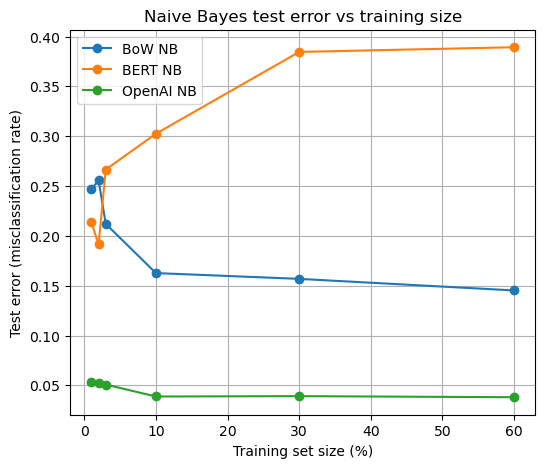

In [115]:
bow_x = [frac * 100 for frac, err in results_bow]
bow_y = [err for frac, err in results_bow]

bert_x = [frac * 100 for frac, err in results_bert]
bert_y = [err for frac, err in results_bert]

open_x = [frac * 100 for frac, err in results_open]
open_y = [err for frac, err in results_open]

plt.figure(figsize=(6,5))
plt.plot(bow_x, bow_y, marker='o', label='BoW NB')
plt.plot(bert_x, bert_y, marker='o', label='BERT NB')
plt.plot(open_x, open_y, marker='o', label='OpenAI NB')
plt.xlabel('Training set size (%)')
plt.ylabel('Test error (misclassification rate)')
plt.title('Naive Bayes test error vs training size')
plt.legend()
plt.grid(True)
plt.show()

Error increases with smaller training sets for BoW and OpenAI embeddings, as expected, but OpenAI remains extremely robust.
BERT embeddings perform the worst due to incompatibility with the Naive Bayes assumptions.
OpenAI > BoW >> BERT in terms of Naive Bayes performance and stability.

## Zero-shot sentiment classification using OpenAI embeddings



In [116]:
pip install --upgrade openai

Note: you may need to restart the kernel to use updated packages.


In [118]:
from openai import OpenAI
client = OpenAI(api_key="OPENAI_API_KEY")

def get_embedding(text, model="text-embedding-3-large"):
    text = text.replace("\n", " ")
    return client.embeddings.create(
        input=[text],
        model=model,
        encoding_format="float"
    ).data[0].embedding

emb_A = get_embedding("This is a positive review.")

emb_B = get_embedding("This is a negative review.")

print(len(emb_A), len(emb_B))

3072 3072


In [119]:
from sklearn.metrics.pairwise import cosine_distances

dist_to_A = cosine_distances(openaiX_test, np.array(emb_A).reshape(1, -1)).ravel()
dist_to_B = cosine_distances(openaiX_test, np.array(emb_B).reshape(1, -1)).ravel()

y_pred_zero_shot = np.where(dist_to_A < dist_to_B, 1, -1)
test_error = np.mean(y_pred_zero_shot != openaiy_test)

print("Zero-shot test error =", test_error)

Zero-shot test error = 0.03340595497458242


Using the zero-shot classification method with prompts “This is a positive review.” / “This is a negative review.” we obtained a test error of 3.34%.

In [121]:
def zero_shot_error_for_prompts(prompt_A, prompt_B):
    emb_A = np.array(get_embedding(prompt_A))
    emb_B = np.array(get_embedding(prompt_B))

    dist_to_A = cosine_distances(openaiX_test, emb_A.reshape(1, -1)).ravel()
    dist_to_B = cosine_distances(openaiX_test, emb_B.reshape(1, -1)).ravel()

    y_pred = np.where(dist_to_A < dist_to_B, 1, -1)
    return np.mean(y_pred != openaiy_test)

prompt_pairs = [
    ("This is a positive review.", "This is a negative review."),
    ("The customer loved this product.", "The customer hated this product."),
    ("The review expresses happiness.", "The review expresses sadness."),
    ("The experience was excellent.", "The experience was terrible."),
    ("The product works very well.", "The product works very badly."),
]

results = []
for A, B in prompt_pairs:
    err = zero_shot_error_for_prompts(A, B)
    results.append((A, B, err))
    print(f"A: {A}\nB: {B}\n   test error = {err:.4f}\n")

best = min(results, key=lambda x: x[2])
print("Best pair:")
print("A:", best[0])
print("B:", best[1])
print("test error:", best[2])


A: This is a positive review.
B: This is a negative review.
   test error = 0.0334

A: The customer loved this product.
B: The customer hated this product.
   test error = 0.0396

A: The review expresses happiness.
B: The review expresses sadness.
   test error = 0.0468

A: The experience was excellent.
B: The experience was terrible.
   test error = 0.0283

A: The product works very well.
B: The product works very badly.
   test error = 0.0309

Best pair:
A: The experience was excellent.
B: The experience was terrible.
Min test error: 0.02832244008714597
